# Implementing a Multilayer Neural Network

In [1]:
import time
import io

import numpy
import pandas

import torch

## Introduction

This walk-through was inspired by [Building Neural Networks with Python Code and Math in Detail  Part II](https://pub.towardsai.net/building-neural-networks-with-python-code-and-math-in-detail-ii-bbe8accbf3d1) and follows my walk-through of [building a perceptron]({filename}perceptron.md).  We will not rehash concepts covered previously and instead move quickly through the parts of building this neural network that follow the same pattern as building a perceptron.

As with the perceptron guide, we first implementing our model using only numpy, then go on to implement it using PyTorch to understand what PyTorch is doing mathematically.

## Problem Statement

As with our previous perceptron, we will be modeling a logical OR gate with two inputs ($x_{1}$ and $x_{2}$), one output ($f$).  Unlike before though, we will create a _multilayer perceptron_ where we chain two linear models together instead of using just one.

First let's get our input loaded.  This time, we'll use a CSV as our input since this is a pretty common data format that we would expect to encounter in the real world.  We load it into a Pandas DataFrame, then peel off the last column to use as our ground-truth results.  The first two columns then become our input:

In [2]:
input_csv = """
observation,input1,input2,output
1,0,0,0
2,0,1,1
3,1,0,1
4,1,1,1
"""

dataset = pandas.read_csv(io.StringIO(input_csv), index_col="observation")
inputs = dataset.iloc[:,:-1].to_numpy().astype('float32')
ground_truth = dataset.iloc[:,-1].to_numpy().reshape(-1, 1).astype('float32')

print("Inputs:\n{}".format(inputs))
print("Truth: \n{}".format(ground_truth))

Inputs:
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
Truth: 
[[0.]
 [1.]
 [1.]
 [1.]]


As before, we have the same _learning rate_ hyperparameter $R$, and we might as well use the same value.  We also have to decide how many iterations of training we wish to use, `NUM_ITERATIONS`.

In [3]:
LEARNING_RATE = 0.05
NUM_ITERATIONS = 10000

### Defining the network

We are implementing a neural network to model the same OR gate as our perceptron network before, so it has the same number of input features (2) and outputs (1) as before.  However, this time we are adding a _hidden layer_ in between with three weights for each input, and it can be of arbitrary "size"--that is to say, it can have as many features as we care to add, and the number of features govern how many weights are used to define it.

There are some heuristics to deciding how to size a hidden layer discussed in [Building Neural Networks with Python Code and Math in Detail  Part II](https://pub.towardsai.net/building-neural-networks-with-python-code-and-math-in-detail-ii-bbe8accbf3d1), but it seems pretty arbitrary to me.  We choose a hidden layer with three features here just because.

In [4]:
NUM_NEURONS_HIDDEN = 3

Now that we know 

1. the size of our inputs (our CSV contains four observations, and each observation has two input features $x_1$ and $x_2$),
2. the size of our hidden layer (we arbitrarily defined it as having three features)
3. the size of our output layer (it has a single value, either 1 or 0)

we can draw the obligatory multilayer neural network graph that every tutorial online seems to have:

[![Graphical representation of our multilayer perceptron](https://mermaid.ink/img/eyJjb2RlIjoiZ3JhcGggTFJcbiAgICB4MS0tIHYxIC0tLSBnMShnKVxuICAgIHgxLS0gdjEgLS0tIGcyKGcpXG4gICAgeDEtLSB2MSAtLS0gZzMoZylcbiAgICB4Mi0tIHYyIC0tLSBnMShnKVxuICAgIHgyLS0gdjIgLS0tIGcyKGcpXG4gICAgeDItLSB2MiAtLS0gZzMoZylcbiAgICBnMShnKS0tIHcxIC0tLSBmXG4gICAgZzIoZyktLSB3MiAtLS0gZlxuICAgIGczKGcpLS0gdzMgLS0tIGYiLCJtZXJtYWlkIjp7InRoZW1lIjoiZGVmYXVsdCIsImZsb3djaGFydCI6eyJjdXJ2ZSI6ImJhc2lzIn19LCJ1cGRhdGVFZGl0b3IiOmZhbHNlfQ)](https://mermaid-js.github.io/mermaid-live-editor/#/edit/eyJjb2RlIjoiZ3JhcGggTFJcbiAgICB4MS0tIHYxIC0tLSBnMShnKVxuICAgIHgxLS0gdjEgLS0tIGcyKGcpXG4gICAgeDEtLSB2MSAtLS0gZzMoZylcbiAgICB4Mi0tIHYyIC0tLSBnMShnKVxuICAgIHgyLS0gdjIgLS0tIGcyKGcpXG4gICAgeDItLSB2MiAtLS0gZzMoZylcbiAgICBnMShnKS0tIHcxIC0tLSBmXG4gICAgZzIoZyktLSB3MiAtLS0gZlxuICAgIGczKGcpLS0gdzMgLS0tIGYiLCJtZXJtYWlkIjp7InRoZW1lIjoiZGVmYXVsdCIsImZsb3djaGFydCI6eyJjdXJ2ZSI6ImJhc2lzIn19LCJ1cGRhdGVFZGl0b3IiOmZhbHNlfQ)

I find these neural network diagrams very confusing because it's never clear to me what each node is supposed to represent (and in fact they represent two different things--sometimes the elements of an input vector, and sometimes a function with distinct inputs and outputs).  So I chose to label every node and edge of the above diagram to help map the visualization to what they represent mathematically.  To be explicit,

- `x1` and `x2` are our input features for a single observation,
- `v1` and `v2` are the weights for our hidden layer, and they are always multiplied by `x1` and `x2`, respectively, to establish our linear model `g`
- `g` is the combination of our linear model (let's call it $\hat{y}(\mathbf{x})$) and its activation function ($g(\hat{y}(\mathbf{x}))$) that make up our hidden layer
- `w1`, `w2`, and `w3` are the weights for our output layer
- `f` is the combination of our linear model (which we'll call $y(\mathbf{x})$) and its activation function ($f(y(\mathbf{x}))$) that make up our output layer

As with the perceptron we implemented in the previous page, we use a _loss function_ and _gradient descent_ to iterate until we find the values for the five weights across the two layers that produce a model that best represents our OR gate.

## Implementation with NumPy

We are using the same linear model and activation function as we did before.  The linear model has the form

$ y(\mathbf{x}) = \mathbf{x} \cdot \mathbf{w} + b$

and the activation function is a sigmoid:

$ \displaystyle A(y) = \frac{1}{1 + e^{-y}}$

which are implemented in Python same as before:

In [5]:
def linear(x, weights, bias):
    return numpy.dot(x, weights) + bias

def sigmoid(x):
    return 1.0 / (1.0 + numpy.exp(-x))

We also have to randomly assign weights again.  Each layer has its own weights that we must initialize:

In [6]:
numpy.random.seed(seed=1)
weights_hidden = numpy.random.rand(inputs.shape[1], NUM_NEURONS_HIDDEN)
weights_output = numpy.random.rand(NUM_NEURONS_HIDDEN, 1)
bias = 0.0

print("Starting hidden layer weights:\n{}\n".format(weights_hidden))
print("Starting output layer weights:\n{}".format(weights_output))

Starting hidden layer weights:
[[4.17022005e-01 7.20324493e-01 1.14374817e-04]
 [3.02332573e-01 1.46755891e-01 9.23385948e-02]]

Starting output layer weights:
[[0.18626021]
 [0.34556073]
 [0.39676747]]


Note that we are **not** using a bias this time around.

The dimensionality of each layer in our neural network is a little more complicated in this multilayer case, which is why I drew the network out:

[![Graphical representation of our multilayer perceptron](https://mermaid.ink/img/eyJjb2RlIjoiZ3JhcGggTFJcbiAgICB4MS0tIHYxIC0tLSBnMShnKVxuICAgIHgxLS0gdjEgLS0tIGcyKGcpXG4gICAgeDEtLSB2MSAtLS0gZzMoZylcbiAgICB4Mi0tIHYyIC0tLSBnMShnKVxuICAgIHgyLS0gdjIgLS0tIGcyKGcpXG4gICAgeDItLSB2MiAtLS0gZzMoZylcbiAgICBnMShnKS0tIHcxIC0tLSBmXG4gICAgZzIoZyktLSB3MiAtLS0gZlxuICAgIGczKGcpLS0gdzMgLS0tIGYiLCJtZXJtYWlkIjp7InRoZW1lIjoiZGVmYXVsdCIsImZsb3djaGFydCI6eyJjdXJ2ZSI6ImJhc2lzIn19LCJ1cGRhdGVFZGl0b3IiOmZhbHNlfQ)](https://mermaid-js.github.io/mermaid-live-editor/#/edit/eyJjb2RlIjoiZ3JhcGggTFJcbiAgICB4MS0tIHYxIC0tLSBnMShnKVxuICAgIHgxLS0gdjEgLS0tIGcyKGcpXG4gICAgeDEtLSB2MSAtLS0gZzMoZylcbiAgICB4Mi0tIHYyIC0tLSBnMShnKVxuICAgIHgyLS0gdjIgLS0tIGcyKGcpXG4gICAgeDItLSB2MiAtLS0gZzMoZylcbiAgICBnMShnKS0tIHcxIC0tLSBmXG4gICAgZzIoZyktLSB3MiAtLS0gZlxuICAgIGczKGcpLS0gdzMgLS0tIGYiLCJtZXJtYWlkIjp7InRoZW1lIjoiZGVmYXVsdCIsImZsb3djaGFydCI6eyJjdXJ2ZSI6ImJhc2lzIn19LCJ1cGRhdGVFZGl0b3IiOmZhbHNlfQ)

but even this diagram doesn't keep the entirety of the network, its functions, and all the different matrix dimensions straight in my head.  So let's define all of the scalar components of our multilayer network explicitly to help us figure out the derivatives we need to perform gradient descent:

1. input values: $\mathbf{x}$
2. hidden layer: $\mathbf{\hat{y}} = \mathbf{x} \cdot \mathbf{v} $
    0. $\hat{y}_{11} = x_{11} v_{11} + x_{12} v_{21} $
    0. $\hat{y}_{21} = x_{21} v_{11} + x_{22} v_{21} $
    0. ...
    0. $\hat{y}_{42} = x_{41} v_{12} + x_{42} v_{22} $
    0. $\hat{y}_{43} = x_{41} v_{13} + x_{42} v_{23} $
3. activation of hidden layer: $ \mathbf{g}(\mathbf{\hat{y}}) = \frac{1}{1+e^{-\mathbf{\hat{y}}}} $
4. output layer: $\mathbf{y} = \mathbf{g} \cdot \mathbf{w}$
    0. $y_{11} = g_{11} w_{11} + g_{12} w_{21} + g_{13} w_{31} $
    0. ...
    0. $y_{41} = g_{41} w_{11} + g_{42} w_{21} + g_{43} w_{31} $
5. activation of output layer: $ \mathbf{f}(\mathbf{y}) = \frac{1}{1+e^{-y}} $

So our neural network with its hidden layer is really expressed as

$ \mathbf{f}(\mathbf{y}(\mathbf{g}(\mathbf{\hat{y}}(\mathbf{x})))) $

Finally, we choose mean-squared error as our loss function:

$ E(f) = \frac{1}{N} \displaystyle \sum^{N} (f - f_{0})^2 $

which has some subtlety since $f$ is really a matrix $\mathbf{f}$, and therefore our loss function $E(f)$ yields a matrix $\mathbf{E}$ whose elements $E_{ij}$ are defined as:

$ E_{ij} = \displaystyle \frac{(f_{ij} - f_{0,ij})^2}{N} $

where $N$ is the number of inputs used to train our neural network and result in the error calculated.

### Gradient descent

Gradient descent in this multilayer case is very similar to gradient descent in the single perceptron case.  A couple of key points:

1. Instead of the output layer taking its input from the input observations, it takes its input from the output of the hidden layer.  The hidden layer takes its input from the input observations
2. Each layer has its own set of weights, so gradient descent is applied to each layer in sequence.
3. The gradient is calculated starting at the output layer, and the chain rule is then applied to connect the gradients of the two layers.

The last point is probably why the process of updating weights throughout a multilayer network is called _backpropagation_.  You have to start at the output and calculate gradients in the reverse direction of the network.

#### Output layer gradient

Calculating the gradient of the error (loss function) with respect to the weights begins at the output layer:

$ \displaystyle \frac{\partial E}{\partial w} =
\frac{\partial E}{\partial f} \cdot
\frac{\partial f}{\partial y} \cdot
\frac{\partial y}{\partial w}
$

where

- $ \frac{\partial E}{\partial f} = \frac{2}{N} ( f - f_0 ) $
- $ \frac{\partial f}{\partial y} = f (1 - f) $
- $ \frac{\partial y}{\partial w} = g$ (in the single perceptron case, $ \frac{\partial y}{\partial w} = x $)

This is the same as gradient descent in the single perceptron case _except_ that the inputs from this layer come from the hidden layer's output, $g(\hat{y})$, instead of the observations $x$.

#### Hidden layer gradient

Calculating the gradient of the hidden layer's weights is the same as the output layer, except the inputs and outputs from this layer are different.  Again, we want to calculate the gradient of the error $E$ with respect to this layer's weights $v$:

$ \displaystyle \frac{\partial E}{\partial v} = 
\frac{\partial E}{\partial g}
\frac{\partial g}{\partial \hat{y}}
\frac{\partial \hat{y}}{\partial v} $

where

- $ \frac{\partial E}{\partial g} =
           \frac{\partial E}{\partial f} \cdot
           \frac{\partial f}{\partial y} \cdot
           \frac{\partial y}{\partial g} $
    - $ \frac{\partial E}{\partial g} =
        \frac{\partial E}{\partial y} \cdot
        \frac{\partial y}{\partial g} $
    - $ \frac{\partial E}{\partial y} =
        \frac{\partial E}{\partial f} \cdot
        \frac{\partial f}{\partial y}$
- $ \frac{\partial g}{\partial \hat{y}} = g (1 - g)$
- $ \frac{\partial \hat{y}}{\partial v} = x$

We rely on chain-rule expanding $\frac{\partial E}{\partial g}$ so we can solve for it in terms of the output layer's partial derivatives.  This is where the two layers' terms connect to each other, and it is how the gradient we calculated for the output layer help us calculate the gradient for this hidden layer.

The only other differences is that this hidden layer takes its input from the observations provided at the beginning of training, $x$.

In [7]:
x = inputs
    
t0 = time.time()
for i in range(NUM_ITERATIONS):
    # define the terms in our gradient descent equations
    w = weights_output
    v = weights_hidden
    yhat = linear(x, v, bias)
    g = sigmoid(yhat)
    y = linear(g, w, bias)
    f = sigmoid(y)
    
    # calculate the mean-squared error for the weights we have
    error = numpy.power(f - ground_truth, 2).mean()
    if i % (NUM_ITERATIONS / 10) == 0:
        print("error at step {:5d}: {:10.6e}".format(i, error))
    
    # calculate out partial derivatives for the output layer's weights
    dE_df = 2.0 * (f - ground_truth) / f.size
    df_dy = f * (1.0 - f)
    dy_dw = g
    dE_dy = dE_df * df_dy
    dE_dw = numpy.dot(dy_dw.T, dE_dy)
    
    # calculate partial derivatives with respect to hidden layer weights
    dy_dg = w
    dE_dg = numpy.dot(dE_dy, dy_dg.T)
    dg_dyhat = g * (1.0 - g)
    dyhat_dv = x
    dE_dyhat = dE_dg * dg_dyhat
    dE_dv = numpy.dot(dyhat_dv.T, dE_dyhat)
    
    # update weights and biases - the error is the sum of error over each input
    weights_hidden -= LEARNING_RATE * dE_dv
    weights_output -= LEARNING_RATE * dE_dw

print("Final weights:")
print("  hidden: {}".format(weights_hidden.flatten()))
print("  output: {}".format(weights_output.flatten()))
print("{:d} iterations took {:.1f} seconds".format(NUM_ITERATIONS, time.time() - t0))

error at step     0: 1.960156e-01
error at step  1000: 1.651662e-01
error at step  2000: 1.593565e-01
error at step  3000: 1.550351e-01
error at step  4000: 1.511067e-01
error at step  5000: 1.465351e-01
error at step  6000: 1.392272e-01
error at step  7000: 1.234844e-01
error at step  8000: 9.350530e-02
error at step  9000: 6.205274e-02
Final weights:
  hidden: [ 1.66707072  2.43454525 -1.50667653  1.66659174  2.29166158 -1.50681196]
  output: [ 0.70570663  2.04736287 -4.12867523]
10000 iterations took 2.7 seconds


We now have a set of weights $\mathbf{v}$ for our hidden layer and $\mathbf{w}$ for our output layer.  To make predictions using these weights, we just run our inputs $\mathbf{x}$ through our trained model $ \mathbf{f}(\mathbf{y}(\mathbf{g}(\mathbf{\hat{y}}(\mathbf{x})))) $.

### Predicting outputs

Since this multilayer perceptron has two layers, we have to

1. Calculate our hidden layer's linear model output, $\hat{y}$, given our input
2. Take the output of $\hat{y}$ and feed it into the hidden layer's activation function, $g(\hat{y})$
3. Take the output of $g(\hat{y})$ and feed it into the output layer's linear model $y(g)$
4. Take the output of $y(g)$ and feed it into the output layer's activation function to get our final prediction, $f(y)$

In [8]:
# traverse the hidden layer
predicted_output = linear(inputs, weights_hidden, bias)
predicted_output = sigmoid(predicted_output)

# traverse the output layer
predicted_output = linear(predicted_output, weights_output, bias)
predicted_output = sigmoid(predicted_output)

# convert output to dataframe
predicted_output = pandas.DataFrame(
    predicted_output,
    columns=["prediction"],
    index=dataset.index)

output = pandas.concat(
    (dataset, predicted_output),
    axis=1)
output['error'] = output['output'] - output['prediction']
print("Predicted vs. actual outputs:")
print(output)

Predicted vs. actual outputs:
             input1  input2  output  prediction     error
observation                                              
1                 0       0       0    0.334522 -0.334522
2                 0       1       1    0.846053  0.153947
3                 1       0       1    0.849022  0.150978
4                 1       1       1    0.925358  0.074642


If you scrutinize the predictions and error from this multilayer model, you'll see that it did a lot worse than our simple perceptron; this is due in part to

1. we are now trying to find the optimal values of _five_ weights instead of two in the same number of iterations of gradient descent
2. we are using a more complicated model to predict the behavior of something that is fundamentally not that complicated

This speaks to the importance of understanding how to match your neural network to the problem it is trying to model.  Although you definitely don't want to underfit the model to the complexity of your inputs and outputs, you also don't want to overfit it.

## Implementation with PyTorch

Now we implement the same multilayer perceptron using PyTorch.  This should look familiar; we're just adding two more layers to our sequential model container to reflect the new hidden layer and its activation function.

In [9]:
model = torch.nn.Sequential(
    torch.nn.Linear(inputs.shape[1], NUM_NEURONS_HIDDEN, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Linear(NUM_NEURONS_HIDDEN, 1, bias=False),
    torch.nn.Sigmoid()
)

In [10]:
numpy.random.seed(seed=1) # use same initial seed as before

with torch.no_grad():
    model[0].weight = torch.nn.Parameter(torch.from_numpy(numpy.random.rand(inputs.shape[1], NUM_NEURONS_HIDDEN).astype(numpy.float32).T))
    # model[0].bias = torch.nn.Parameter(torch.from_numpy(numpy.random.rand(1, 1)))
    model[2].weight = torch.nn.Parameter(torch.from_numpy(numpy.random.rand(NUM_NEURONS_HIDDEN, 1).astype(numpy.float32).T))
print("Starting hidden layer weights:\n{}\n".format(model[0].weight))
print("Starting output layer weights:\n{}".format(model[2].weight))

Starting hidden layer weights:
Parameter containing:
tensor([[4.1702e-01, 3.0233e-01],
        [7.2032e-01, 1.4676e-01],
        [1.1437e-04, 9.2339e-02]], requires_grad=True)

Starting output layer weights:
Parameter containing:
tensor([[0.1863, 0.3456, 0.3968]], requires_grad=True)


And as PyTorch does, expressing the gradient descent process using PyTorch is much more straightforward since it automatically calculates our gradients for us.

In [11]:
inputs_tensor = torch.from_numpy(inputs)
truth_tensor = torch.from_numpy(ground_truth.reshape(-1, 1))

loss = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

model.train()
t0 = time.time()
for i in range(NUM_ITERATIONS):
    f = model(inputs_tensor)

    error = loss(f, truth_tensor)
    if i % (NUM_ITERATIONS / 10) == 0:
        print("error at step {:5d}: {:10.6e}".format(i, error))

    optimizer.zero_grad()
    
    error.backward()
    
    optimizer.step()

print("Final weights:")
print("  hidden: {}".format(next(model[0].parameters()).detach().numpy().flatten()))
print("  output: {}".format(next(model[2].parameters()).detach().numpy().flatten()))
print("{:d} iterations took {:.1f} seconds".format(NUM_ITERATIONS, time.time() - t0))

error at step     0: 1.960156e-01
error at step  1000: 1.651661e-01
error at step  2000: 1.593565e-01
error at step  3000: 1.550351e-01
error at step  4000: 1.511067e-01
error at step  5000: 1.465351e-01
error at step  6000: 1.392272e-01
error at step  7000: 1.234844e-01
error at step  8000: 9.350532e-02
error at step  9000: 6.205267e-02
Final weights:
  hidden: [ 1.6670684  1.6665915  2.4345472  2.2916615 -1.5066769 -1.5068121]
  output: [ 0.70570666  2.0473638  -4.128679  ]
10000 iterations took 10.6 seconds


Once again, prediction is equally straightforward.  We switch our model from training mode to evaluation mode, then run our inputs through it to get our predictions.

In [12]:
model.eval()

predicted_output = model(inputs_tensor).detach().numpy()
predicted_output = pandas.DataFrame(
    predicted_output,
    columns=["prediction"],
    index=dataset.index)

output = pandas.concat(
    (dataset, predicted_output),
    axis=1)
output['error'] = output['output'] - output['prediction']
print("Predicted vs. actual outputs:")
print(output)

Predicted vs. actual outputs:
             input1  input2  output  prediction     error
observation                                              
1                 0       0       0    0.334522 -0.334522
2                 0       1       1    0.846053  0.153947
3                 1       0       1    0.849022  0.150978
4                 1       1       1    0.925358  0.074642


## Where Multilayer Shines: The XOR Gate

We showed above that our multilayer perceptron neural network is worse than the single perceptron case; in the same number of training iterations, our multilayer perceptron had much higher error.  If this is the case, what is the benefit of using a hidden layer at all?

The single perceptron is ideally suited to model OR gates because OR gates are _linearly separable_, and single perceptrons are only able to model such linearly separable behavior.  If we want to see where the multilayer perceptron does shine, let's look at a _non-linearly separable_ logic gate: the XOR gate.

First define our truth table which we will use for both models:

In [13]:
xor_input_csv = """
observation,input1,input2,output
1,0,0,0
2,0,1,1
3,1,0,1
4,1,1,0
"""

xor_dataset = pandas.read_csv(io.StringIO(xor_input_csv), index_col="observation")
xor_inputs = xor_dataset.iloc[:,:-1].to_numpy().astype('float32')
xor_ground_truth = xor_dataset.iloc[:,-1].to_numpy().reshape(-1, 1).astype('float32')

xor_inputs_tensor = torch.from_numpy(xor_inputs)
xor_truth_tensor = torch.from_numpy(xor_ground_truth.reshape(-1, 1))

print(xor_dataset)

             input1  input2  output
observation                        
1                 0       0       0
2                 0       1       1
3                 1       0       1
4                 1       1       0


Then we define both our single perceptron network and the multilayer perceptron.

The single perceptron is identical to the one we made in the [previous perceptron walk-through]({filename}perceptron.md); it has two inputs, one output, two weights, a bias, and we use the total absolute error (`torch.nn.L1Loss`).

The multilayer perceptron is the same one we just created; it has two inputs, one output, a hidden layer with three features and a total of five weights, _no bias_, and we use the mean-squared error (`torch.nn.MSELoss`).

In [14]:
torch.manual_seed(0)

single_perceptron = torch.nn.Sequential(
    torch.nn.Linear(xor_inputs.shape[1], 1),
    torch.nn.Sigmoid(),
)

multilayer_perceptron = torch.nn.Sequential(
    torch.nn.Linear(xor_inputs.shape[1], NUM_NEURONS_HIDDEN),
    torch.nn.Sigmoid(),
    torch.nn.Linear(NUM_NEURONS_HIDDEN, 1, bias=False),
    torch.nn.Sigmoid()
)

Because the multilayer perceptron is slower to converge on good weights, we dial up the number of iterations on both networks here to let them do their best to find their optimal weights.

In [15]:
NUM_ITERATIONS = 50000

Let's also track the error throughout training so we can visualize how quickly each model converges on good weights.

In [16]:
errors = {
    'single perceptron': [],
    'multilayer perceptron': []
}

In [17]:
loss = torch.nn.L1Loss(reduction='sum')
optimizer = torch.optim.SGD(single_perceptron.parameters(), lr=LEARNING_RATE)

# train network
single_perceptron.train()
t0 = time.time()
for i in range(NUM_ITERATIONS):
    f = single_perceptron(xor_inputs_tensor)
    error = loss(f, xor_truth_tensor)
    if i % (NUM_ITERATIONS / 100) == 0:
        errors['single perceptron'].append((i, error))
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
print("{:d} iterations took {:.1f} seconds".format(NUM_ITERATIONS, time.time() - t0))
print("Final error: {:.2g}\n".format(error))

# predict outputs
single_perceptron.eval()
predicted_output = single_perceptron(xor_inputs_tensor).detach().numpy()
predicted_output = pandas.DataFrame(
    predicted_output,
    columns=["prediction"],
    index=xor_dataset.index)
output = pandas.concat((xor_dataset, predicted_output), axis=1)
output['error'] = output['output'] - output['prediction']

print("Predicted vs. actual outputs for the single perceptron network:")
print(output)

50000 iterations took 39.9 seconds
Final error: 1

Predicted vs. actual outputs for the single perceptron network:
             input1  input2  output    prediction     error
observation                                                
1                 0       0       0  1.231995e-03 -0.001232
2                 0       1       1  9.983570e-01  0.001643
3                 1       0       1  1.666987e-09  1.000000
4                 1       1       0  8.205257e-04 -0.000821


We can see that our single perceptron neural network completely failed to predict one of the inputs.  If you start with different random weights, you'll see that exactly which input comes out completely wrong is random--this is because there's nothing particularly tricky about predicting any one input; rather, the combination of all inputs are not linearly separable, so the best our model can do is correctly predict three out of the four.

How does our multilayer perceptron fare by comparison?

In [18]:
loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(multilayer_perceptron.parameters(), lr=LEARNING_RATE)

# train network
multilayer_perceptron.train()
t0 = time.time()
for i in range(NUM_ITERATIONS):
    f = multilayer_perceptron(xor_inputs_tensor)
    error = loss(f, xor_truth_tensor)
    if i % (NUM_ITERATIONS / 100) == 0:
        errors['multilayer perceptron'].append((i, error))
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
print("{:d} iterations took {:.1f} seconds".format(NUM_ITERATIONS, time.time() - t0))
print("Final error: {:.2g}\n".format(error))

# predict outputs
multilayer_perceptron.eval()
predicted_output = multilayer_perceptron(xor_inputs_tensor).detach().numpy()
predicted_output = pandas.DataFrame(
    predicted_output,
    columns=["prediction"],
    index=xor_dataset.index)
output = pandas.concat((xor_dataset, predicted_output), axis=1)
output['error'] = output['output'] - output['prediction']

print("Predicted vs. actual outputs for the multilayer perceptron network:")
print(output)

50000 iterations took 58.0 seconds
Final error: 0.07

Predicted vs. actual outputs for the multilayer perceptron network:
             input1  input2  output  prediction     error
observation                                              
1                 0       0       0    0.049976 -0.049976
2                 0       1       1    0.926449  0.073551
3                 1       0       1    0.925168  0.074832
4                 1       1       0    0.517742 -0.517742


We no longer have one of the four predictions be completely wrong anymore!  However, one is still looking pretty messed up, so this multilayer perceptron still isn't quite sufficient for modeling our XOR gate.

If we plot how the error varied over the course of training, we can get a little more insight into how the network is learning:

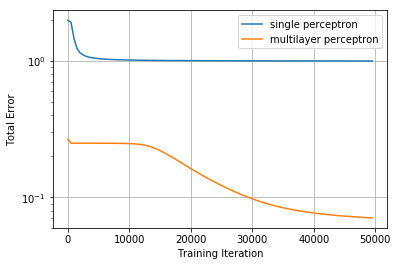

In [20]:
import matplotlib
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots()
for key, values in errors.items():
    iterations, error = zip(*values)
    ax.plot(iterations, error, label=key)
ax.set_yscale("log")
ax.set_ylabel("Total Error")
ax.set_xlabel("Training Iteration")
ax.legend()
ax.grid()

This tells us two interesting things:

1. The single perceptron converges very quickly, but it converges on a set of weights that results in a high overall error.
2. The multilayer perceptron spends quite a while just flapping around and not really getting anywhere before it finds a path to start converging on some better weights.

This tells us that the single perceptron network was unlikely to ever get close to a lower error no matter how much we trained.  By comparison, the multilayer perceptron's error was still dropping when we stopped training at 50,000 steps by comparison which means we still had room to improve.  However, the rate at which error was dropping looks like it started leveling off, and we were unlikely to get substantially lower error by training more.

This is pretty dissatisfying because our results, despite being better than the single perceptron case, still had a value that was pretty far off the mark.  Does this mean that multilayer perceptrons aren't any good at modeling this XOR gate?  Does it mean that this particular multilayer perceptron is no good and we should try a different number of neurons or loss function?

It turns out the answer is NO!  For example, try starting with different random weights by changing the `torch.manual_seed(0)` statement above to `torch.manual_seed(1)`.  When I did this, I wound up with four final predictions that were all within 0.10 of the ground truth!  Relatedly, try an extra feature (neuron) to your hidden layer.  This will scramble your starting weights and add change the behavior of this learning rate.  When I did this, I wound up getting a much lower error.

This speaks to how _artisinal_ this process of designing neural networks to model phenomena like OR or XOR gates can be.  Your model might give you bad results because it woke up on the wrong side of the bed (had bad starting weights) or its hidden layer had a bad hyperparameter (you chose too many or too few features).  Searching for the right hyperparameters to get your model to return good predictions consistently can be a huge task by itself.  Maybe it's possible to develop a good sense of the right place to start when designing neural network for specific scenarios, but until you develop that sixth sense, it may be easier to start with someone else's neural network architecture for a similar problem and begin tweaking from there.